In [1]:
%matplotlib inline

# Basic micromagnetics
The goal of micromagnetics is to compute the equilibrium magnetization configuration of a given magnetic sample. Its physical shape is modeled by the mesh. The size of the mesh cells is limited by a physical length scale originating from the ferromagnetic exchange interaction and we need to compute the magnetization configuration that arises, when an external magnetic field (the Zeeman field) is applied along a certain spatial direction. The micromagnetic moments $\vec{m}$ sitting on the sites of the mesh nodes will start to align themselves with the external field, but are also subject to the nearest-neighbour interaction from the exchange. The equation of motion describing the magnetization reversal is the Landau-Lifshitz-Gilbert equation

$$
\frac{d\vec{m}}{dt} = -\frac{\gamma}{1 + \alpha^2}\left(\vec{m} \times \vec{H}_{\mathrm{eff}}\right) - \frac{\gamma\alpha}{1 + \alpha^2} \left[\vec{m} \times \left(\vec{m} \times \vec{H}_{\mathrm{eff}}\right)\right]
$$

given here in its explicit form with the gyromagnetic ration $\gamma$ and the Gilbert damping parameter $\alpha$. $\vec{H}_{\mathrm{eff}}$ is the effective field acting on the magnetic moment, which in reality consists of more terms than the Zeeman and exchange fields only. It is computed from the functional derivative of the total magnetic energy density $w (\vec{m})$

$$
\vec{H}_{\mathrm{eff}}(\vec{m}) = -\frac{1}{\mu_0 M_S}\frac{\delta w (\vec{m})}{\delta \vec{m}}
$$

where

$$
w (\vec{m}) = A(\nabla \vec{m})^2 - \mu_0 M_S \vec{m}\cdot \vec{H}.
$$

The used constants are the vacuum permeability $\mu_0$, the saturation magnetization $M_S$, the ferromagnetic exchange constant $A$ and the Zeeman field $\vec{H}$.


In [2]:
import fenics as df
import numpy as np
import matplotlib.pyplot as plt

# Material parameters
Ms = 8.6e5  # saturation magnetisation (A/m)
alpha = 0.1  # Gilbert damping
gamma = 2.211e5  # gyromagnetic ratio
A = 1e-11 # exchange constant (J/m)

# External magentic field.
B = 0.1  # (T)
mu0 = 4 * np.pi * 1e-7  # vacuum permeability

# Zeeman field
H = Ms / 2 * df.Constant((0,0,1))
# meaningful time period is of order of nano seconds
dt = 1e-12

# mesh parameters
d = 10e-9
thickness = 10e-9
nx = ny = 2
nz = 1

# create mesh
p1 = df.Point(0, 0, 0)
p2 = df.Point(d, d, thickness)
mesh = df.BoxMesh(p1, p2, nx, ny, nz)

# define function space for magnetization
V = df.VectorFunctionSpace(mesh, "CG", 1, dim=3)

# define initial M and normalise
m_init = df.Constant((1, 0, 0))
m = df.interpolate(m_init, V)
v = df.TestFunction(V)

def energy_density(m):
    w_Zeeman = - mu0 * Ms * df.dot(m, H)
    w_exchange = A  * df.inner(df.grad(m), df.grad(m))
    w = w_Zeeman + w_exchange
    return w

def effective_field(w, m, volume=None):
    return - 1/mu0 * df.derivative(w / Ms * df.dx, m)
    # snippet for box method: [do we need it??]
    # Heff = df.assemble(dE_dm).array()/volume

def LLG(Heff, m, alpha, gamma):
    tmp1 = -gamma/(1+alpha*alpha)*df.cross(m, Heff) - alpha*gamma/(1+alpha*alpha)*df.cross(m, df.cross(m, Heff))
    # get form that can be turned into vector using 'assemble'
    dmdt = df.dot(tmp1, df.TestFunction(V)) * df.dP
    return dmdt
    
def turn_form_to_function(form, vectorspace):
    """Given a form, compute a function, by projecting the form and the
    desired solution u_sol onto test functions.
    
    This can probably be done more efficiently; review later.
    
    Help from FEniCS team will be very welcome in re-working this example.
    """
    V = vectorspace
    u = df.TrialFunction(V)
    v = df.TestFunction(V)
    a = df.dot(u, v) * df.dx
    L = form * v 
    u_sol = df.Function(V)
    df.solve(a==L, u_sol)
    return u_sol


def compute_dmdt(m):
    """Convenience function that does all in one go"""
    
    Heff_function = turn_form_to_function(Heff_form, V)
    dmdt = LLG(Heff_function, m, alpha, gamma)
    return dmdt


# hamiltonian
w = energy_density(m)
# and related effective field
Heff_form = effective_field(w, m)




/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
# function for integration of system of ODEs

def rhs_micromagnetic(m_vector_array, t, counter=[0]):
    if counter[0] % 10 == 0:
        print("{:5} Called with t={}".format(counter[0], t))
    counter[0] += 1
    # convert m_vector into function
    assert isinstance(m_vector_array, np.ndarray)
    m.vector()[:] = m_vector_array[:]
    dmdt = compute_dmdt(m)
    # convert to vector
    dmdt_vector = df.assemble(dmdt)
    return dmdt_vector.array()

## Integrate ODEs with scipy.integrate

In [4]:
%%time
from scipy.integrate import odeint
m_init = df.Constant((1, 0, 0))
m = df.interpolate(m_init, V)
ts = np.linspace(0, 5e-10, 100)

# empty call of time integrator, just to get FEniCS to cache all forms etc
rhs_micromagnetic(m.vector().array(), 0)

    0 Called with t=0
CPU times: user 30 ms, sys: 20 ms, total: 50 ms
Wall time: 72.3 ms


In [5]:
%%time 

ms = odeint(rhs_micromagnetic, y0=m.vector().array(), t=ts)

   10 Called with t=1.28095110944e-13
   20 Called with t=2.156961396e-13
   30 Called with t=4.78499225567e-13
   40 Called with t=2.76443272939e-12
   50 Called with t=7.2327101493e-12
   60 Called with t=1.30302918587e-11
   70 Called with t=1.96547936665e-11
   80 Called with t=2.68101680743e-11
   90 Called with t=3.39369183859e-11
  100 Called with t=4.04182997127e-11
  110 Called with t=4.68996810395e-11
  120 Called with t=5.46903199096e-11
  130 Called with t=6.24809587797e-11
  140 Called with t=7.02559852216e-11
  150 Called with t=7.80271085564e-11
  160 Called with t=8.57699775496e-11
  170 Called with t=9.34940103149e-11
  180 Called with t=9.98867481011e-11
  190 Called with t=1.06377299147e-10
  200 Called with t=1.13014570082e-10
  210 Called with t=1.20849581199e-10
  220 Called with t=1.28760159524e-10
  230 Called with t=1.35775266495e-10
  240 Called with t=1.42909077414e-10
  250 Called with t=1.501220243e-10
  260 Called with t=1.58002293238e-10
  270 Called with

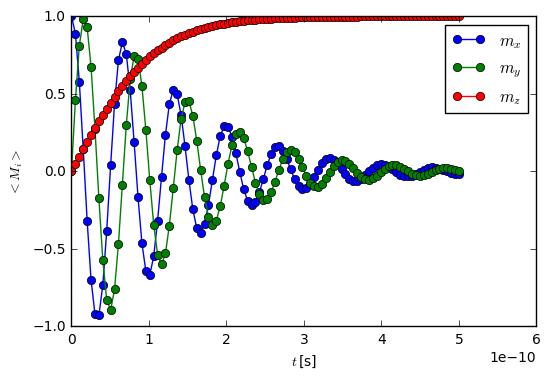

In [6]:
import pylab
tmp2 = ms[:,0:3]  # might be m_x, m_y, m_z of first vector
pylab.plot(ts, tmp2, 'o-')
pylab.legend(['$m_x$', '$m_y$', '$m_z$'])
pylab.xlabel('$t\,$[s]')
pylab.ylabel('$<M_i>$')